In [11]:
%matplotlib inline
import sys # system information
import matplotlib # plotting
import scipy # scientific computing
import random 
import pandas as pd # data managing
from scipy.special import comb
from scipy import stats as st
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations 
# Matplotlib setting
plt.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi']= 300
np.random.seed(20220928) # Consistent random effect

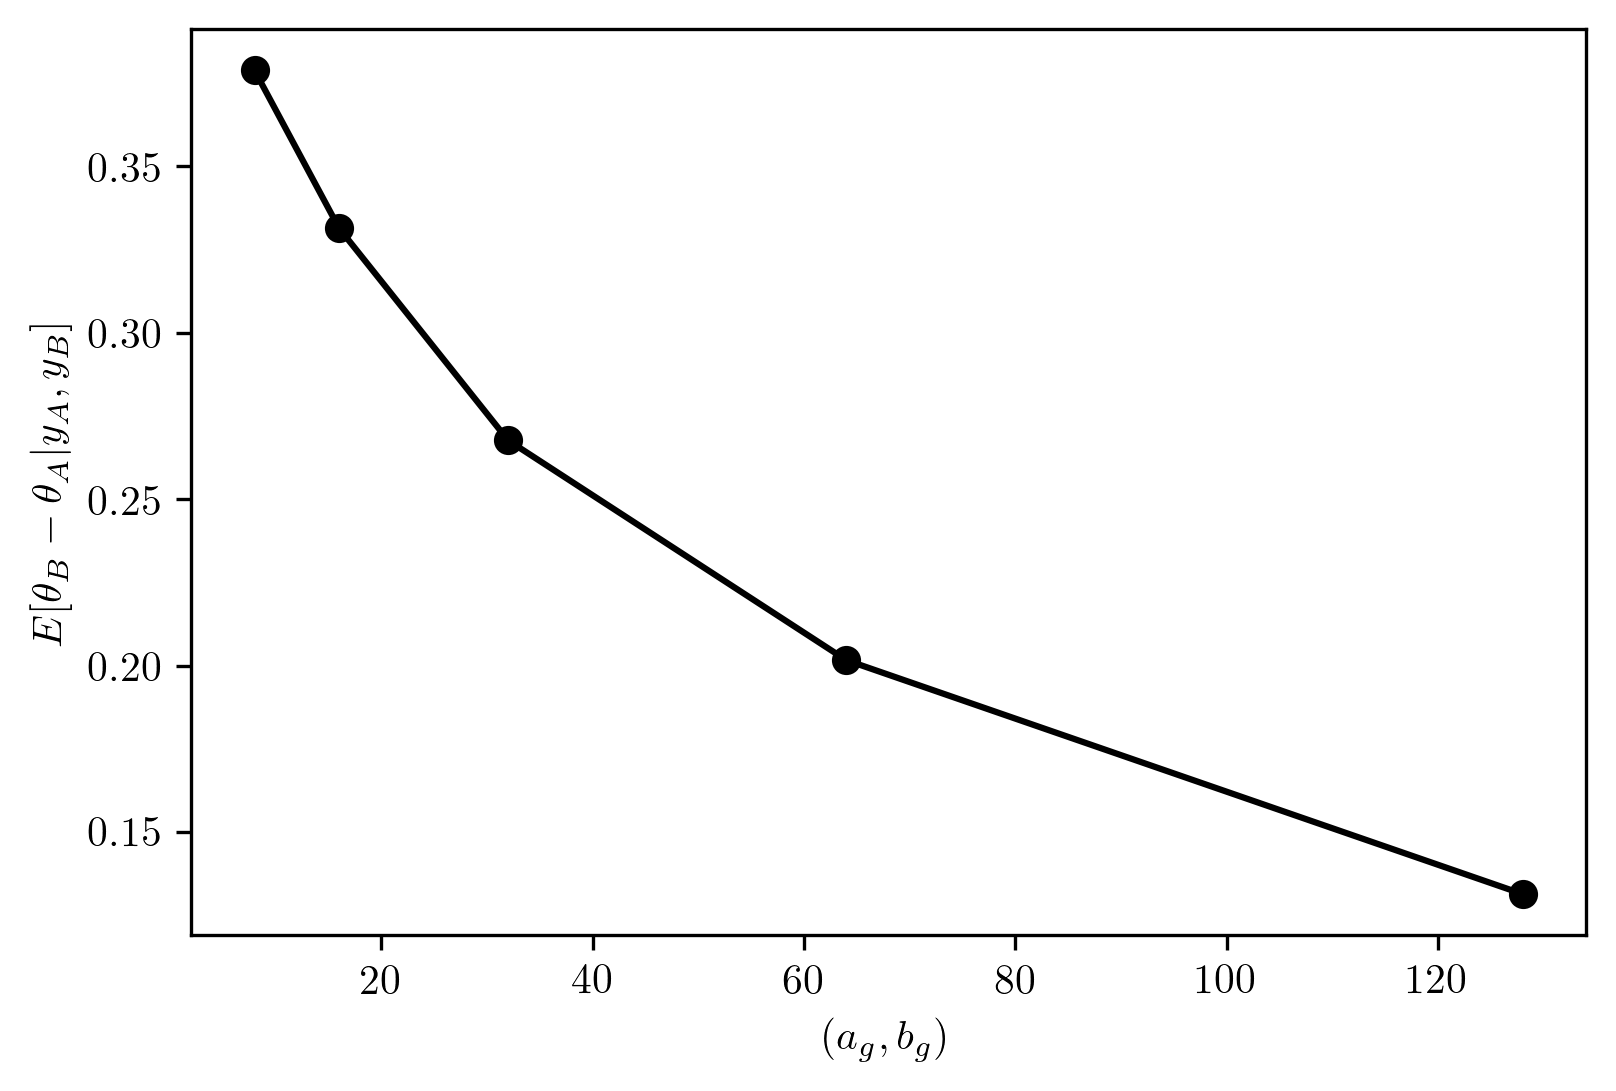

In [25]:
class GibbSampler:
    def __init__(self, a_t, b_t, a_g, b_g):
        # Theta
        self.a_t = 2
        self.b_t = 1
        # Gamma
        self.a_g = a_g
        self.b_g = b_g
        self.theta = st.gamma(a_t, scale=1/b_t)
        self.gamma = st.gamma(a_g, scale=1/b_g)

    def expection(self, obs_func, dataA, dataB, n_sampling):
        # Sample number
        nA=len(dataA)
        nB= len(dataB)
        # Sample mean
        mA = np.mean(dataA)
        mB = np.mean(dataB)
        
    
        thetaAs = np.zeros(n_sampling) 
        thetaBs = np.zeros(n_sampling)

        # initial
        theta_pre = st.gamma.rvs(self.a_t, scale=(self.b_t)**-1)
        gamma_pre = st.gamma.rvs(self.a_g, scale=(self.b_g)**-1)

        # Gibbs iteration
        thetaAs[0] = theta_pre
        thetaBs[0] = theta_pre*gamma_pre
        
        for i in range(1,n_sampling):
            # posterior
            theta = st.gamma.rvs(nA*mA + nB*mB + self.a_t, scale= (nA + nB*gamma_pre + self.b_t)**-1)
            theta_pre = theta
            gamma = st.gamma.rvs(nB*mB + self.a_g, scale= (nB*theta_pre + self.b_g)**-1)
            gamma_pre = gamma
    
            # transformation
            thetaAs[i] = theta
            thetaBs[i] = theta*gamma
        
        # Apply obs
        obs = [obs_func(thetaAs[i], thetaBs[i]) for i in range(0,n_sampling)]
        
        return np.mean(obs)


def obs_func(theta_A, theta_B):
    return theta_B - theta_A


vals = np.array([8,16,32,64,128], dtype=float)       

priors = [{\
    "a_t": 2.0,
    "b_t": 1.0,
    "a_g": a,
    "b_g": a
} for a in vals]

obs = {
    "obs_func": obs_func, 
    "dataA": np.loadtxt("data/menchild30bach.dat"), 
    "dataB": np.loadtxt("data/menchild30nobach.dat"), 
    "n_sampling": 5000
}

exps = np.zeros(len(vals))

for i in range(0, len(vals)):
    g = GibbSampler(**priors[i])
    exps[i] = g.expection(**obs)


plt.plot(vals, exps, "-o",color="black");
plt.xlabel("$(a_{g}, b_{g})$");
plt.ylabel("$E[\\theta_{B}-\\theta_{A} | y_A, y_{B}]$");